In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from matplotlib.font_manager import FontProperties

PALETTE=['lightcoral', 'lightskyblue', 'gold', 'sandybrown', 'navajowhite',
        'khaki', 'lightslategrey', 'turquoise', 'rosybrown', 'thistle', 'pink']
sns.set_palette(PALETTE)
BACKCOLOR = '#f6f5f5'

from IPython.core.display import HTML

In [159]:
# ตั้งค่าฟอนต์ที่รองรับภาษาไทย
font_path = '.\THSarabun.ttf'  # เปลี่ยนเป็นที่ตั้งของฟอนต์ที่รองรับภาษาไทย
font_thai = FontProperties(fname=font_path, size=20)
font_path

'.\\THSarabun.ttf'

## 👩‍💻 User Modules

In [3]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

In [4]:
def cat_dist(data, var, hue, msg_show=True):
    total_cnt = data[var].count()
    f, ax = plt.subplots(1, 2, figsize=(25, 8))
    hues = [None, hue]
    titles = [f"{var}'s distribution", f"{var}'s distribution by {hue}"]
    

    for i in range(2):
        sns.countplot(data[var], edgecolor='black', hue=hues[i], linewidth=1, ax=ax[i], data=data)
        ax[i].set_xlabel(var, weight='bold', size=15)
        ax[i].set_ylabel('Count', weight='bold', size=15)
        ax[i].set_facecolor(BACKCOLOR)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_title(titles[i], size=15, weight='bold')\
        +3
        ax[i].tick_params(axis='x', labelsize=15, rotation=45)  # Adjust font size for x-axis labels
        ax[i].tick_params(axis='y', labelsize=15)
        #ax[i].tick_params(axis='x', pad=8)
    
        for patch in ax[i].patches:
            x, height, width = patch.get_x(), patch.get_height(), patch.get_width()
            if msg_show:
                ax[i].text(x + width / 2, height + 3, f'{height} \n({height / total_cnt * 100:2.2f}%)', va='center', ha='center', size=12, bbox={'facecolor': 'white', 'boxstyle': 'round'})
    

    plt.show()

In [5]:
def continuous_dist(data, x, y):
    f, ax = plt.subplots(1, 4, figsize=(35, 10))
    sns.histplot(data=bank, x=y, hue=x, ax=ax[0], element='step')
    sns.violinplot(x=data[x], y=data[y], ax=ax[1], edgecolor='black', linewidth=1)
    sns.boxplot(x=data[x], y=data[y], ax=ax[2])
    sns.stripplot(x=data[x], y=data[y], ax=ax[3])
    for i in range(4):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].set_xlabel(x, weight='bold', size=20)
        ax[i].set_ylabel(y, weight='bold', size=20)
        ax[i].set_facecolor(BACKCOLOR)
    f.suptitle(f"{y}'s distribution by {x}", weight='bold', size=25)
    plt.show()

## 💾 Read Data

In [6]:
bank = pd.read_csv('bank-full.csv',delimiter=';')

In [7]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [8]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [9]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


# Column Discription 

1. age : Integer, int64
2. job : Categorical, object
    * Occupation Types :
        - 2.1 'admin.',
        - 2.2 'blue-collar',
        - 2.3 'entrepreneur',
        - 2.4 'housemaid',
        - 2.5 'management',
        - 2.6 'retired',
        - 2.7 'self-employed',
        - 2.8 'services',
        - 2.9 'student',
        - 2.10 'technician',
        - 2.11 'unemployed',
        - 2.12 'unknown'
3. marital : Categorical, object
   * marital status categorical: 
     - 3.1 'divorced',
     - 3.2 'married',
     - 3.3 'single',
     - 3.4 'unknown'; 
   * note: 'divorced' means divorced or widowed)
4. education : Categorical, object
    * Education Level :
        - 4.1 'basic.4y',
        - 4.2 'basic.6y',
        - 4.3 'basic.9y',
        - 4.4 'high.school',
        - 4.5 'illiterate',
        - 4.6 'professional.course',
        - 4.7 'university.degree',
        - 4.8 'unknown'
5. default : Binary, object 
    * has credit in default? 
    * เครดิตที่ผิดนัดชำระหนี้ หมายถึง การที่ลูกหนี้ไม่สามารถชำระหนี้ตามกำหนดชำระได้ 
        - 5.1 "yes",
        - 5.2 "no"
6. balance : Integer, int64
    * average yearly balance
    * ยอดคงเหลือเฉลี่ยรายปี
7. housing : Binary, object
    * has housing loan?
    * มีสินเชื่อบ้านหรือไม่
8. loan : Binary, object
    * has personal loan?
9. contact : Categorical, object
    * contact communication type :
        - 9.1 "unknown",
        - 9.2 "telephone",
        - 9.3 "cellular" 
10. day : int64
    *  last contact day of the month 
    * วันที่ติดต่อครั้งสุดท้ายของเดือน
    * วันที่ลูกค้าติดต่อธนาคารหรือสถาบันการเงินครั้งสุดท้ายของเดือน โดยวันที่ติดต่ออาจรวมถึงการโทรเข้า การโทรออก การส่งอีเมล หรือการติดต่อผ่านช่องทางอื่นๆ
11. month : object
    * last contact month of year
12. duration : int64
    * last contact duration, in seconds
    * ระยะเวลาติดต่อล่าสุด, ในหน่วยวินาที

## other attributes:
13. campaig : Integer, int64
    * จำนวนครั้งที่ติดต่อที่ดำเนินการในระหว่างแคมเปญนี้และสำหรับลูกค้านี้ (รวมถึงการติดต่อครั้งล่าสุด)
14. pdays : int64
    * จำนวนวันที่ผ่านไปหลังจากที่ลูกค้าได้รับการติดต่อครั้งสุดท้ายจากแคมเปญก่อนหน้า (ตัวเลข, -1 หมายถึงลูกค้าไม่ได้รับการติดต่อในแคมเปญก่อนหน้า)
    * ความถี่ในการติดต่อ
15. previous : int64
    * จำนวนครั้งที่ติดต่อที่ดำเนินการก่อนแคมเปญนี้และสำหรับลูกค้านี้ 
16. poutcome : object
    * outcome of the previous marketing campaign :
        - 16.1 "unknown",
        - 16.2 "other",
        - 16.3 "failure",
        - 16.4 "success"
17. y : object 
    * ลูกค้าได้สมัครเงินฝากประจำแล้วหรือไม่

## 🔎 EDA

### 1. Check Data🔎

In [10]:
bank.head(10).style.background_gradient()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [11]:
print(f'\033[ bank size : {bank.shape[0]} x {bank.shape[1]}')

[ bank size : 45211 x 17


In [12]:
""""TUST11.drop(['TenY_Later','Edu_Improtant_Y', 'Problem', 'Destination', 'YU',
            'งานอดิเรก / กิจกรรมยามว่าง','วิชาที่ชอบคืออะไร ทำไมถึงชอบวิชานี้','อันดับ'], 1, inplace=True)"""

'"TUST11.drop([\'TenY_Later\',\'Edu_Improtant_Y\', \'Problem\', \'Destination\', \'YU\',\n            \'งานอดิเรก / กิจกรรมยามว่าง\',\'วิชาที่ชอบคืออะไร ทำไมถึงชอบวิชานี้\',\'อันดับ\'], 1, inplace=True)'

In [13]:
#TUST11 = TUST11.dropna(axis=0)
#TUST11.rename(columns = {'คำนำหน้า':'Title'}, inplace = True)

In [14]:
bank.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [15]:
bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [16]:
multi_table([pd.DataFrame(bank[i].value_counts()) for i in bank.columns if i != 'age '])

,age
32,2085
31,1996
33,1972
34,1930
35,1894
...,...
90,2
92,2
93,2
95,2


In [17]:
nominal_vars = ['job ', 'marital', 'education', 'default','housing','loan','contact','day','month','poutcome','y']
continuous_vars = ['age','balance','duration','campaign','pdays','previous']

### 2. Detail Explore 🔎

### 🎯 Y (Target)

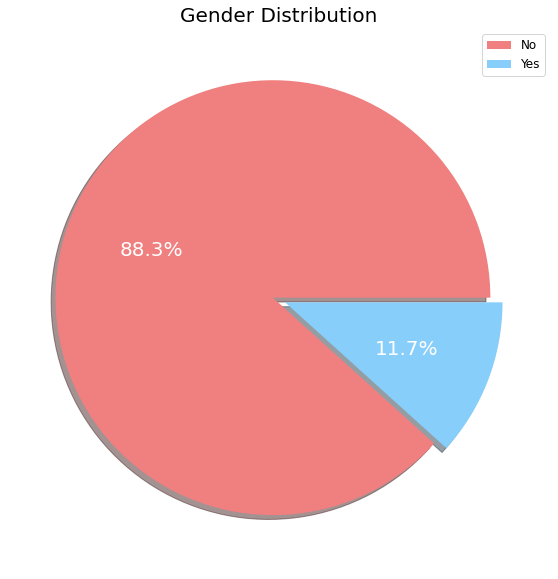

In [18]:
plt.subplots(figsize=(25, 10))
plt.pie(bank.y.value_counts(), shadow=True, explode=[.03,.03], autopct='%1.1f%%', textprops={'fontsize': 20, 'color': 'white'})
plt.title('Gender Distribution', size=20)
plt.legend(['No', 'Yes'], loc='best', fontsize=12)
plt.show()

### 🧮 job (nominal)

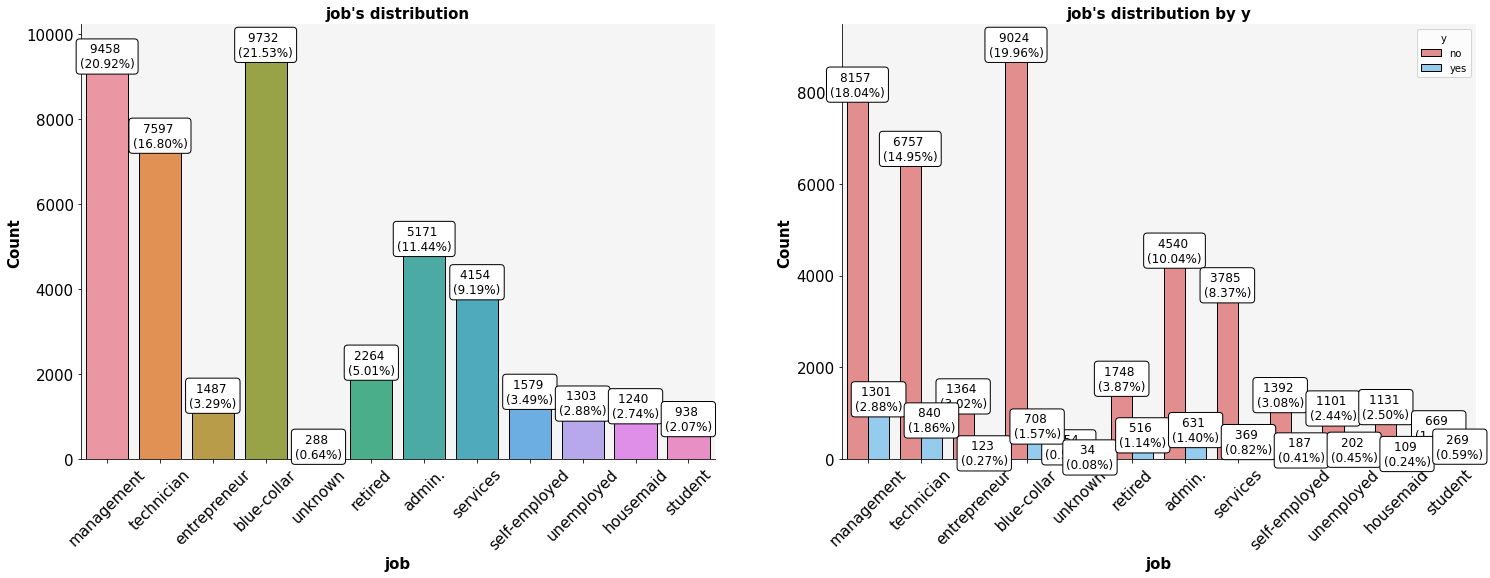

In [19]:
cat_dist(bank, var='job', hue='y')

### 🧮 marital (nominal)

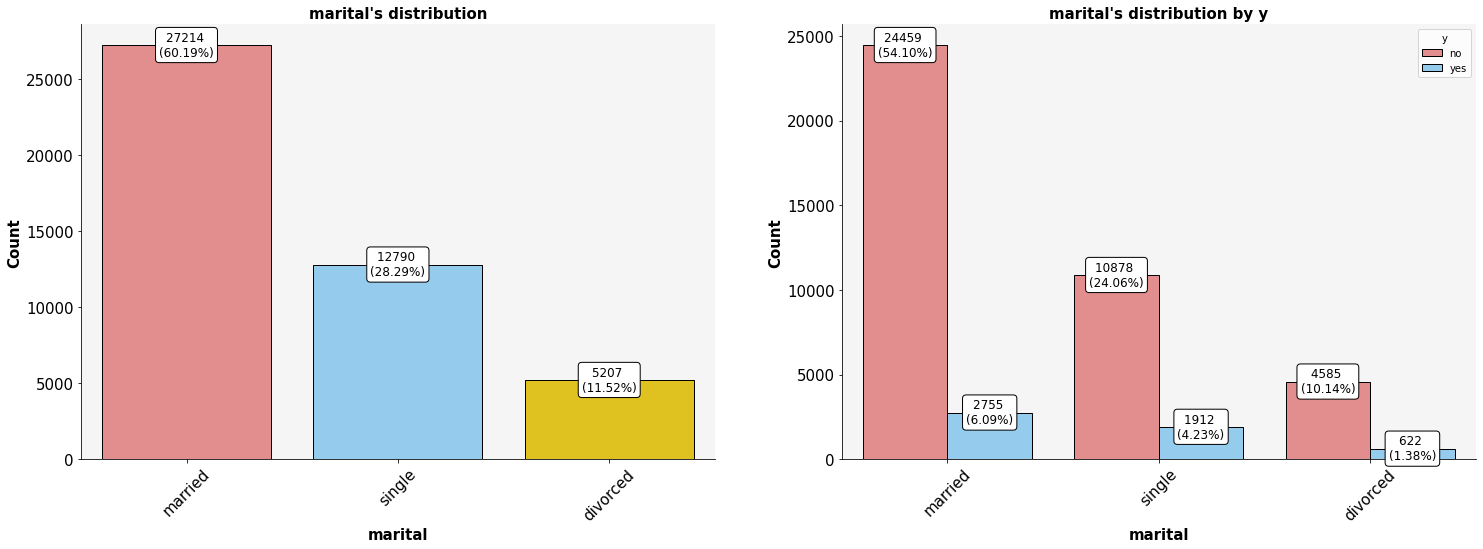

In [20]:
cat_dist(bank, var='marital', hue='y')

### 🧮 education (nominal)

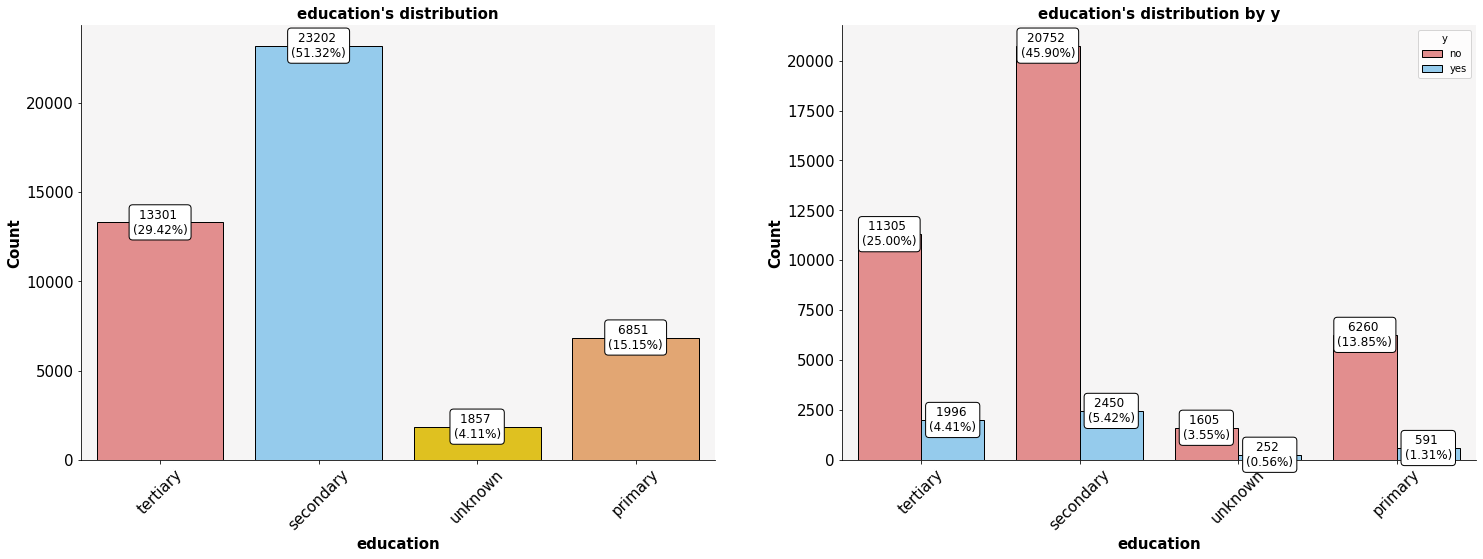

In [21]:
cat_dist(bank, var='education', hue='y')

### 🧮default (niminal)

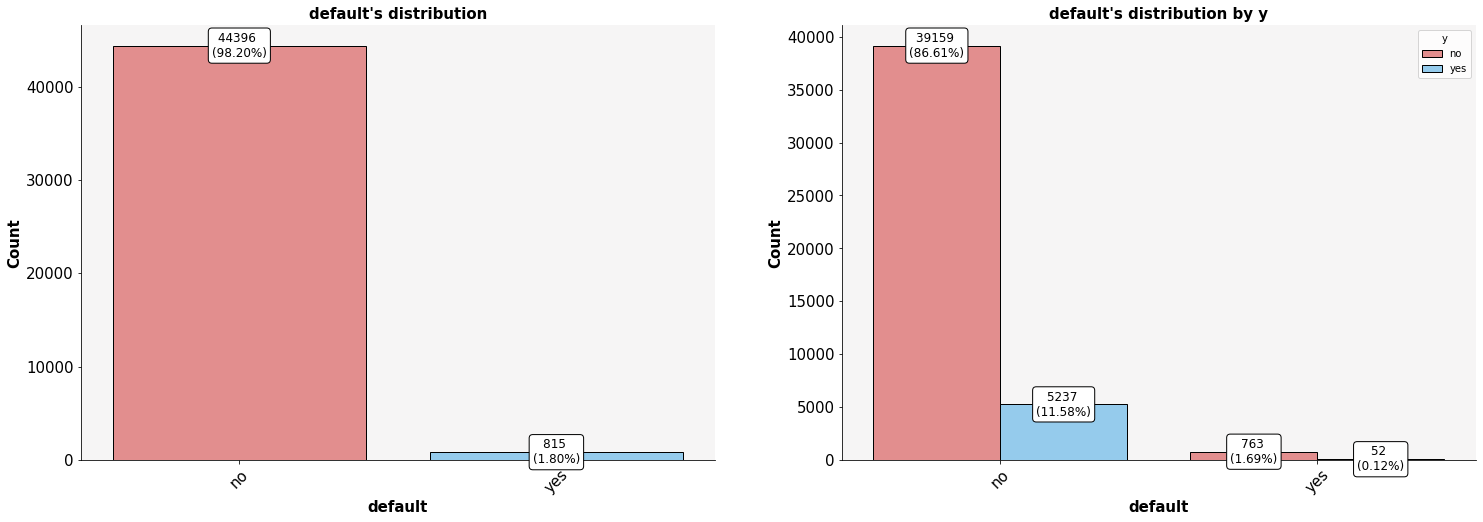

In [22]:
cat_dist(bank, var='default', hue='y')

### 🧮 housing (nominal)

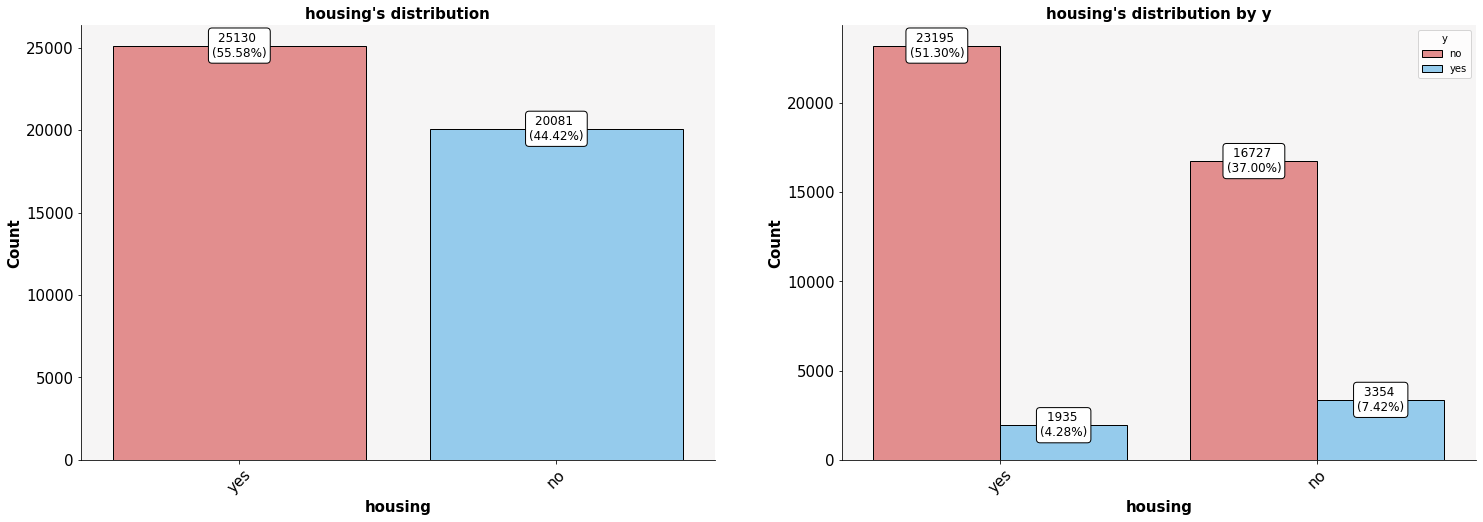

In [23]:
cat_dist(bank, var='housing', hue='y')

### 🧮 loan (nominal)

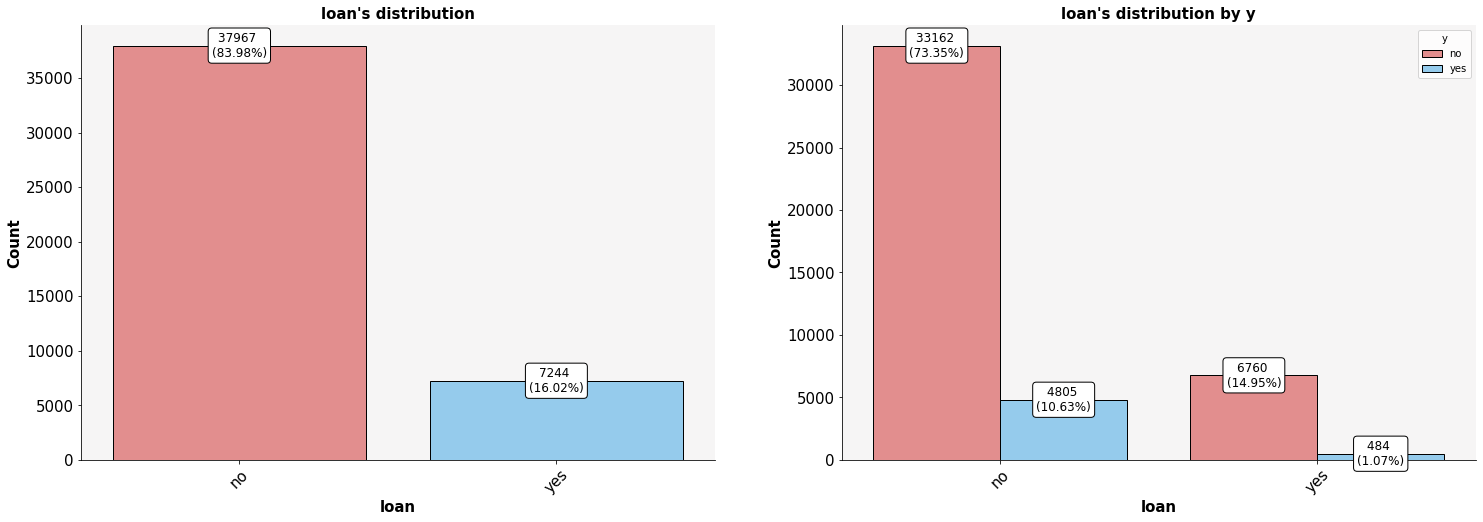

In [24]:
cat_dist(bank, var='loan', hue='y')

### 🧮 contact (nominal)

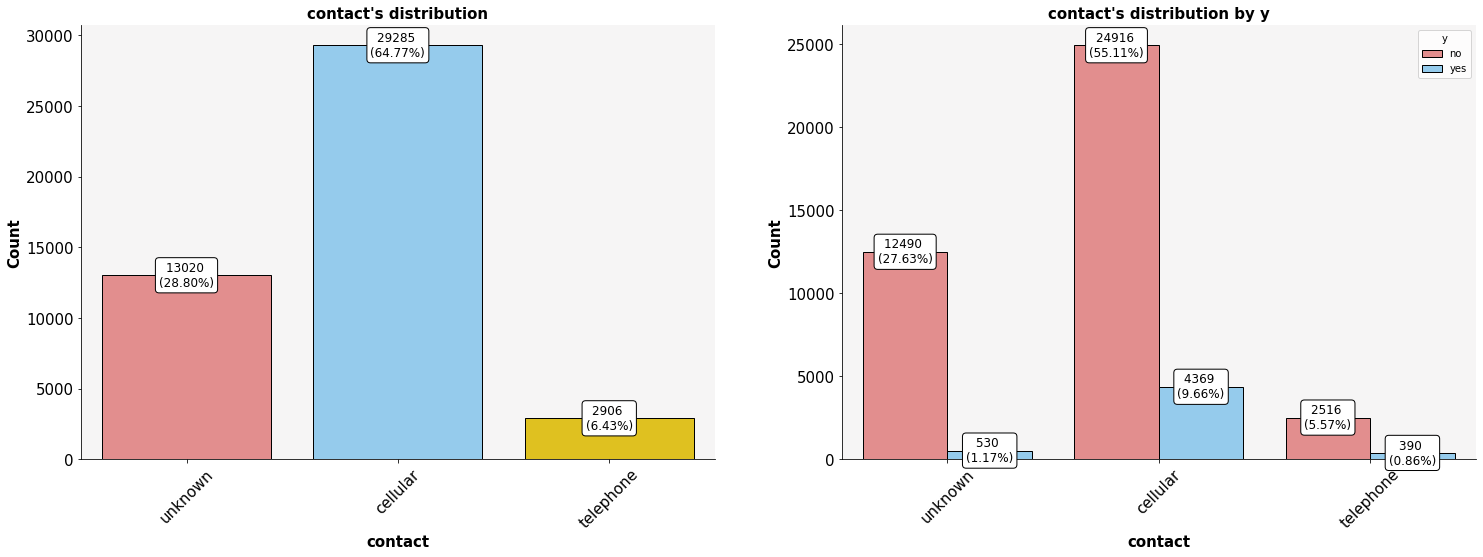

In [25]:
cat_dist(bank, var='contact', hue='y')

### 🧮 month (nominal)

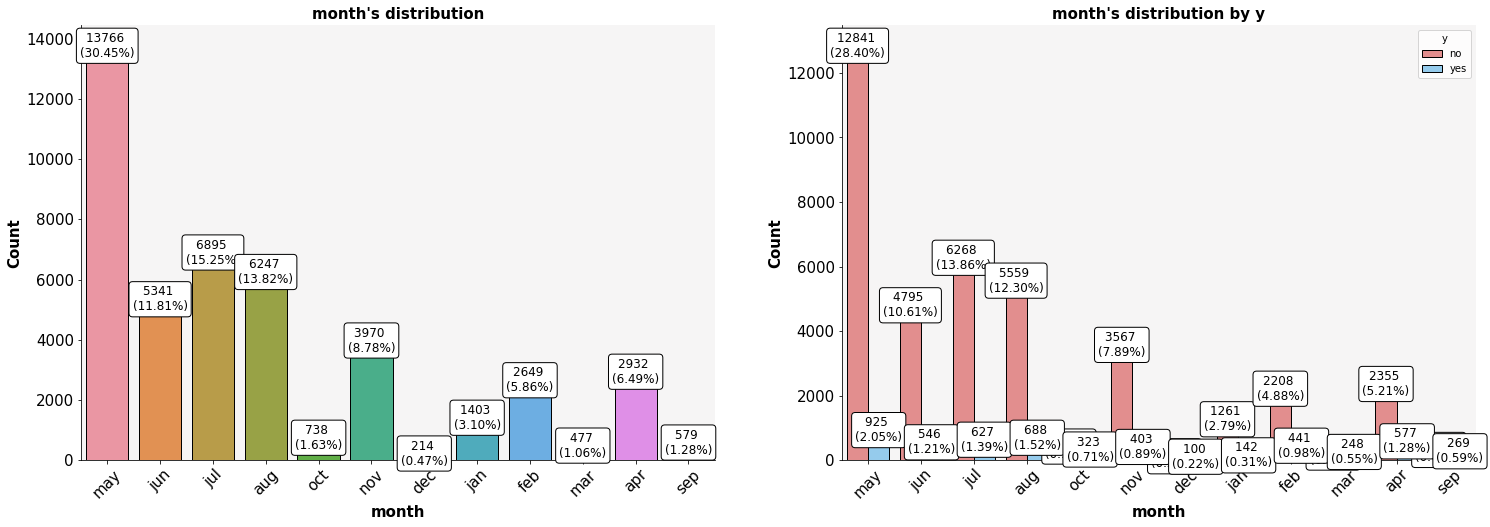

In [26]:
cat_dist(bank, var='month', hue='y')

### 🧮 poutcome (nominal)

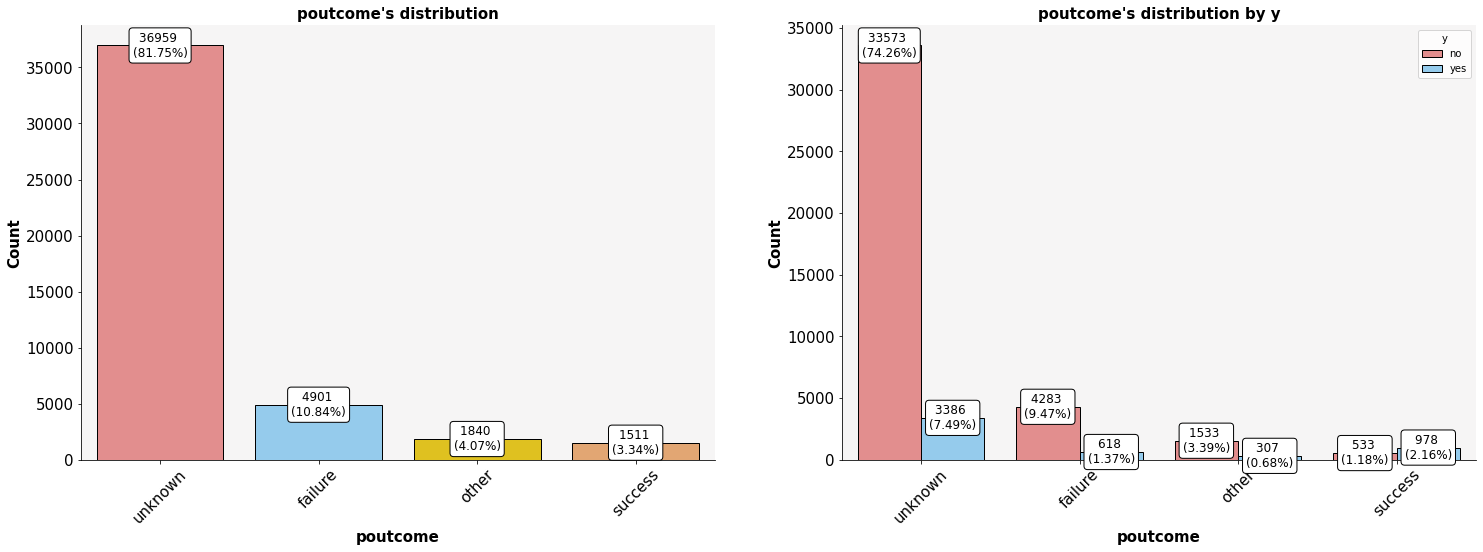

In [27]:
cat_dist(bank, var='poutcome', hue='y')

### 🧮 day (nominal)

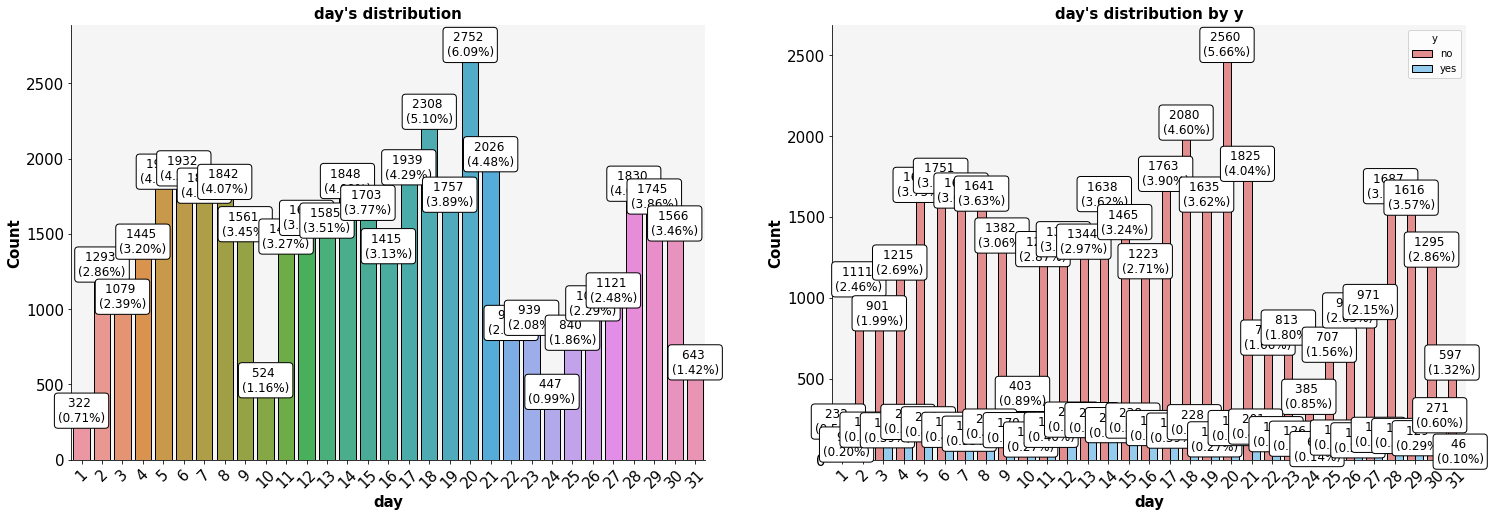

In [28]:
cat_dist(bank, var='day', hue='y')

In [35]:
""""def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

list(split(range(len(days.day.unique())),6))"""

In [58]:
""""days = bank.copy()

days['dayBin'] = 5
for i in range(7):
    days.loc[(days.day >= 5*i) & (days.day < 5*(i + 1)), 'dayBin'] = i

In [82]:
days = bank.copy()

bin_edges = [0, 5, 10, 15, 20, 25, 31]
bin_labels = ['1-5', '6-10', '11-15', '16-20', '21-25', '26-31']

# Create a new column 'dayBin' to store the bin values
days['dayBin'] = pd.cut(days['day'], bins=bin_edges, labels=bin_labels, include_lowest=True, right=True)

# Print the DataFrame with the new 'dayBin' column
days

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,dayBin
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,1-5
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,1-5
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,1-5
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,1-5
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,1-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes,16-20
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes,16-20
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes,16-20
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no,16-20


In [99]:
#days[(days['dayBin'] == 1-5)]
for label in bin_labels:
    unique_values_for_label = days.loc[days['dayBin'] == label, 'day'].unique()
    print(f"Unique values for {label}: {unique_values_for_label}")

Unique values for 1-5: [5 2 3 4 1]
Unique values for 6-10: [ 6  7  8  9 10]
Unique values for 11-15: [12 13 14 15 11]
Unique values for 16-20: [16 19 20 17 18]
Unique values for 21-25: [21 23 24 25 22]
Unique values for 26-31: [26 27 28 29 30 31]


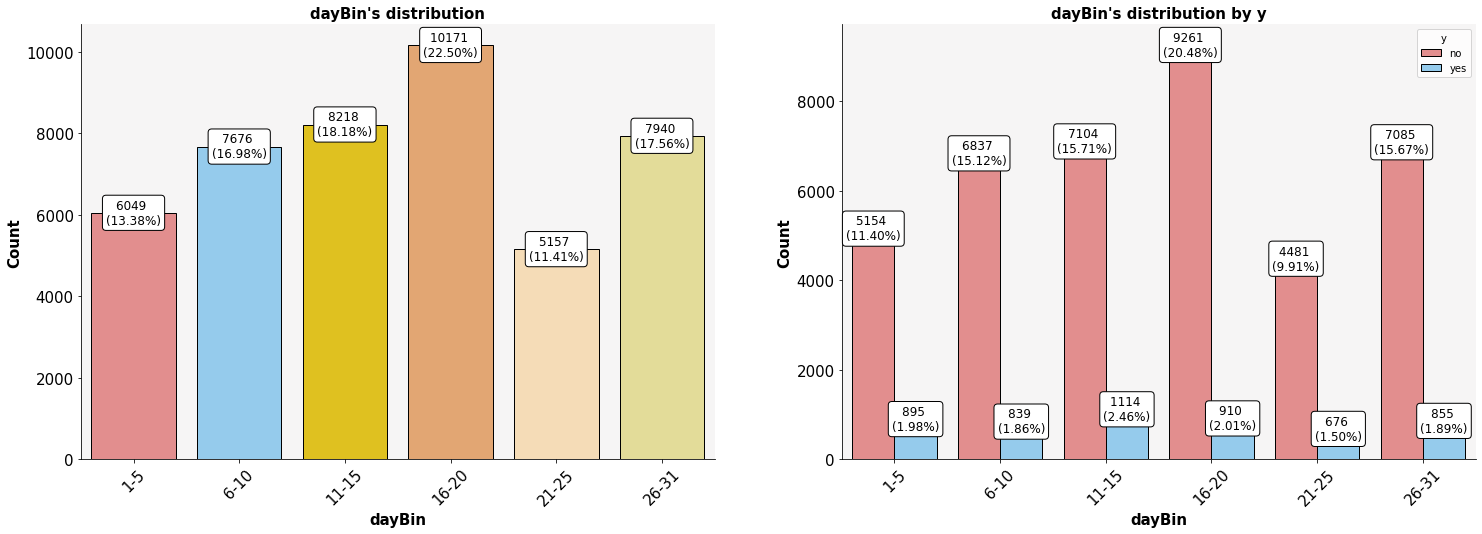

In [83]:
cat_dist(days, var='dayBin', hue='y', msg_show=True)

### age (continuous)

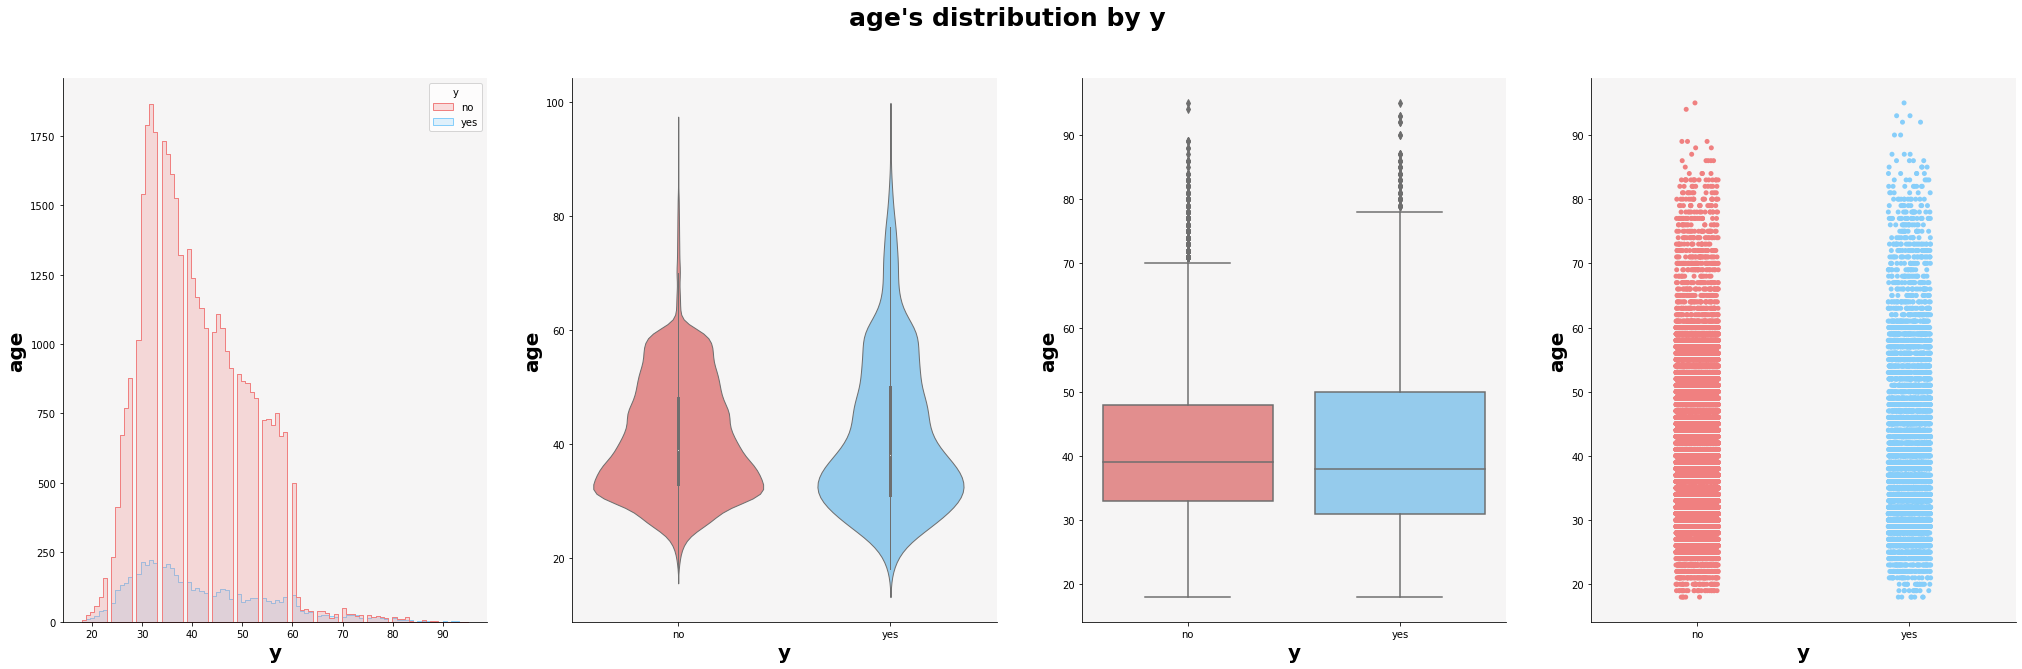

In [62]:
continuous_dist(bank, 'y', 'age')

In [110]:
days.age.unique().max()

95

In [ ]:
""""bin_edges = [0, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = ['1-5', '6-10', '11-15', '16-20', '21-25', '26-31']

# Create a new column 'dayBin' to store the bin values
days['dayBin'] = pd.cut(days['day'], bins=bin_edges, labels=bin_labels, include_lowest=True, right=True)

# Print the DataFrame with the new 'dayBin' column
days"""

In [125]:
# Define bin edges and labels for generations
bin_edges = [0, 20, 45, 65, 95]
generation_labels = ['Gen Z', 'Millennials', 'Gen X', 'Baby Boomers']

# Create a new column 'AgeBin' to store the bin values
days['AgeBin'] = pd.cut(days['age'], bins=bin_edges, labels=generation_labels, include_lowest=True, right=False)

# Print the DataFrame with the new 'AgeBin' column
days


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,dayBin,AgeBin
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,1-5,Gen X
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,1-5,Millennials
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,1-5,Millennials
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,1-5,Gen X
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,1-5,Millennials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes,16-20,Gen X
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes,16-20,Baby Boomers
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes,16-20,Baby Boomers
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no,16-20,Gen X


In [126]:
for label in generation_labels:
    unique_values_for_label = days.loc[days['AgeBin'] == label, 'age'].unique()
    print(f"Unique values for {label}: {unique_values_for_label}")

Unique values for Gen Z: [19 18]
Unique values for Millennials: [44 33 35 28 42 43 41 29 32 25 40 39 36 37 24 38 31 30 27 34 23 26 22 21
 20]
Unique values for Gen X: [58 47 53 57 51 45 60 56 52 46 49 59 50 54 55 48 61 62 64 63]
Unique values for Baby Boomers: [66 83 75 67 70 65 68 69 72 71 76 85 90 82 73 74 78 80 94 79 77 86 81 89
 84 87 92 93 88]


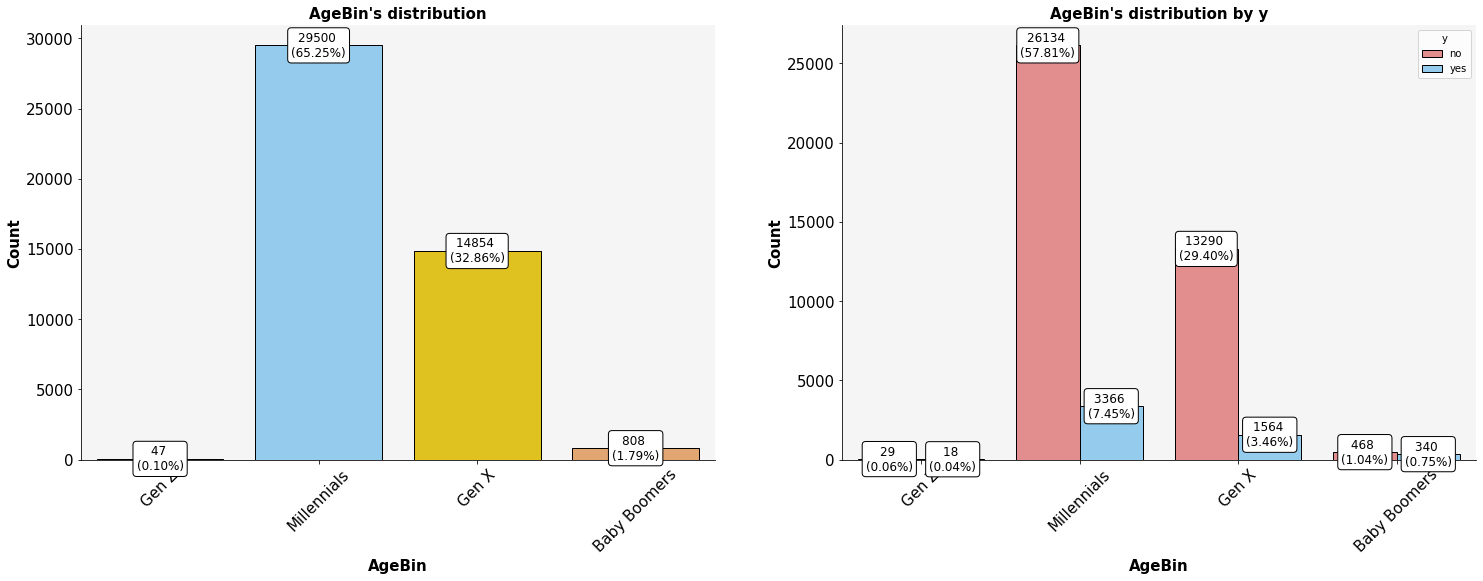

In [127]:
cat_dist(days, var='AgeBin', hue='y', msg_show=True)

### balance, duration, campaign, pdays, previous (continuous)

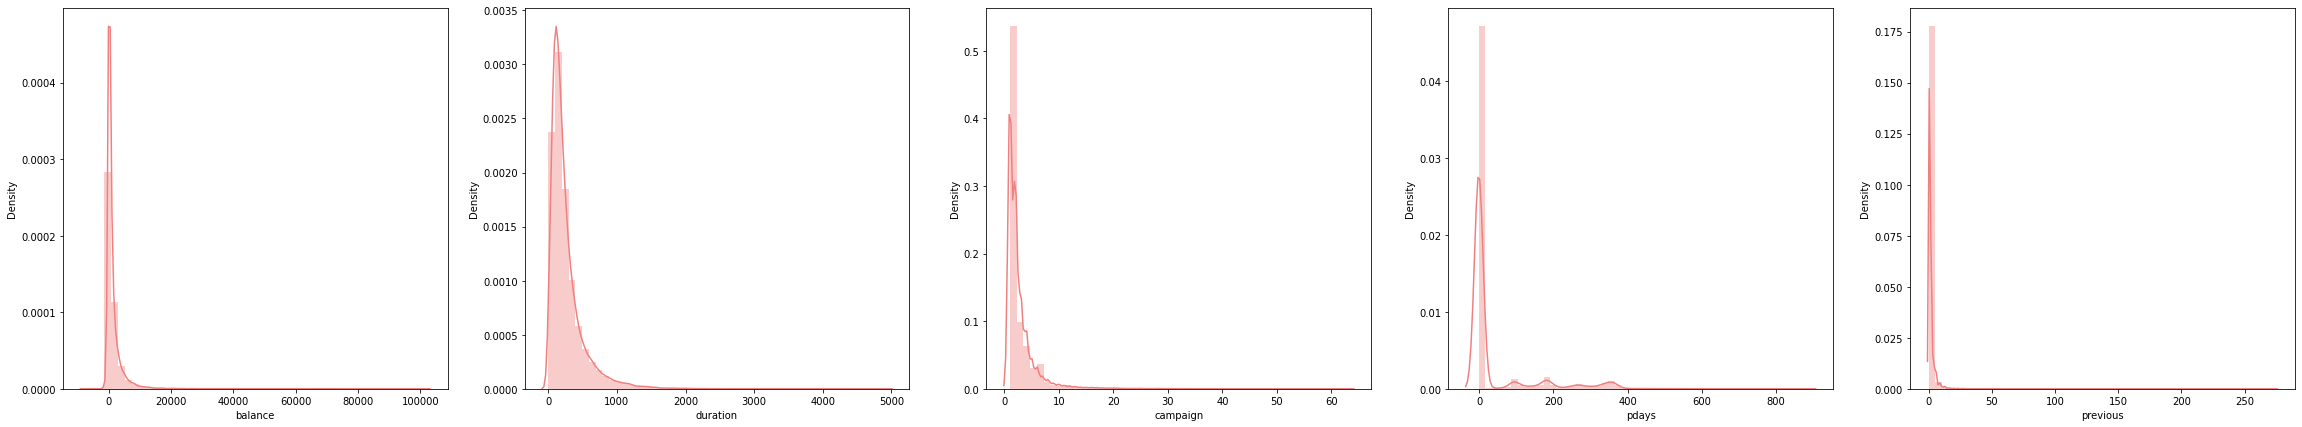

In [141]:
f, ax = plt.subplots(1, 5, figsize=(40, 7))
sns.distplot(bank.balance, ax=ax[0])
sns.distplot(bank.duration, ax=ax[1])
sns.distplot(bank.campaign, ax=ax[2])
sns.distplot(bank.pdays, ax=ax[3])
sns.distplot(bank.previous, ax=ax[4])
plt.show()

##  Multinomial Explore

In [149]:
days['housing'] = days['housing'].replace("yes", "True")
days['housing'] = days['housing'].replace("no", "False")

days['y'] = days['y'].replace("yes", "True")
days['y'] = days['y'].replace("no", "False")

In [160]:
# Heatmap can visualize continuous values (or binary variables) in categories and categories.
"""
plt.subplots(figsize=(10, 5))
g = sns.heatmap(days.pivot_table(index='job', columns='housing', values='y'), annot=True, cmap="YlGnBu")
g.set_title('y ratio by job and housing', weight='bold', size=15)
g.set_xlabel('housing', weight='bold', size=13)
g.set_ylabel('job', weight='bold', size=13)
plt.show()
pd.crosstab([days.housing, days.y], days.job,margins=True).style.background_gradient() """

'\nplt.subplots(figsize=(10, 5))\ng = sns.heatmap(days.pivot_table(index=\'job\', columns=\'housing\', values=\'y\'), annot=True, cmap="YlGnBu")\ng.set_title(\'y ratio by job and housing\', weight=\'bold\', size=15)\ng.set_xlabel(\'housing\', weight=\'bold\', size=13)\ng.set_ylabel(\'job\', weight=\'bold\', size=13)\nplt.show()\npd.crosstab([days.housing, days.y], days.job,margins=True).style.background_gradient() '

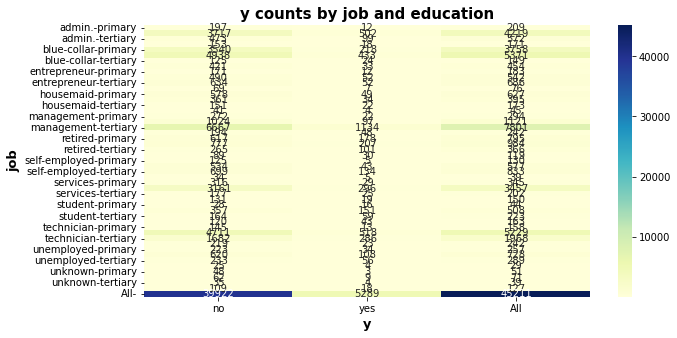

In [162]:
# Create a contingency table using crosstab
contingency_table = pd.crosstab([bank.job, bank.education], bank.y, margins=True)

# Create a heatmap
plt.subplots(figsize=(10, 5))
g = sns.heatmap(contingency_table, annot=True, cmap="YlGnBu", fmt='g')
g.set_title('y counts by job and education', weight='bold', size=15)
g.set_xlabel('y', weight='bold', size=13)
g.set_ylabel('job', weight='bold', size=13)
plt.show()

In [163]:
# Cross tabulation between GENDER and APPROVE_LOAN
CrosstabResult=pd.crosstab(index=bank['job'],columns=bank['y'])
print(CrosstabResult)
 
# importing the required function
from scipy.stats import chi2_contingency
 
# Performing Chi-sq test
ChiSqResult = chi2_contingency(CrosstabResult)
 
# P-Value is the Probability of H0 being True
# If P-Value&gt;0.05 then only we Accept the assumption(H0)
 
print('The P-Value of the ChiSq Test is:', ChiSqResult[1])

y                no   yes
job                      
admin.         4540   631
blue-collar    9024   708
entrepreneur   1364   123
housemaid      1131   109
management     8157  1301
retired        1748   516
self-employed  1392   187
services       3785   369
student         669   269
technician     6757   840
unemployed     1101   202
unknown         254    34
The P-Value of the ChiSq Test is: 3.337121944935502e-172


In [170]:
#nominal_vars = ['job ', 'marital', 'education', 'default','housing','loan','contact','day','month','poutcome','y']
#continuous_vars = ['age','balance','duration','campaign','pdays','previous']

In [177]:
## Importing required libraries
import os as os
import pandas as pd
from itertools import product
import numpy as np
import scipy.stats as ss

## Creating a DataFrame with all categorical variables
bank_cat = pd.DataFrame(data = bank.dtypes, columns = 
                                         ['a']).reset_index()
cat_var = list(bank_cat['index'].loc[bank_cat['a'] == 'object'])
cat_var

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [178]:
## Let us split this list into two parts
cat_var1 = ('job','marital','education','default','housing','loan','contact','month','poutcome','y')
cat_var2 = ('job','marital','education','default','housing','loan','contact','month','poutcome','y')

In [180]:
cat_var_prod = list(product(cat_var1,cat_var2, repeat = 1))
cat_var_prod

[('job', 'job'),
 ('job', 'marital'),
 ('job', 'education'),
 ('job', 'default'),
 ('job', 'housing'),
 ('job', 'loan'),
 ('job', 'contact'),
 ('job', 'month'),
 ('job', 'poutcome'),
 ('job', 'y'),
 ('marital', 'job'),
 ('marital', 'marital'),
 ('marital', 'education'),
 ('marital', 'default'),
 ('marital', 'housing'),
 ('marital', 'loan'),
 ('marital', 'contact'),
 ('marital', 'month'),
 ('marital', 'poutcome'),
 ('marital', 'y'),
 ('education', 'job'),
 ('education', 'marital'),
 ('education', 'education'),
 ('education', 'default'),
 ('education', 'housing'),
 ('education', 'loan'),
 ('education', 'contact'),
 ('education', 'month'),
 ('education', 'poutcome'),
 ('education', 'y'),
 ('default', 'job'),
 ('default', 'marital'),
 ('default', 'education'),
 ('default', 'default'),
 ('default', 'housing'),
 ('default', 'loan'),
 ('default', 'contact'),
 ('default', 'month'),
 ('default', 'poutcome'),
 ('default', 'y'),
 ('housing', 'job'),
 ('housing', 'marital'),
 ('housing', 'educatio

In [183]:
## Creating an empty variable and picking only the p value from the output of Chi-Square test
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(ss.chi2_contingency(pd.crosstab(bank[i[0]], bank[i[1]])))[1]))
result

[('job', 'marital', 0.0),
 ('job', 'education', 0.0),
 ('job', 'default', 8.008039925006771e-09),
 ('job', 'housing', 0.0),
 ('job', 'loan', 5.937325371287369e-103),
 ('job', 'contact', 0.0),
 ('job', 'month', 0.0),
 ('job', 'poutcome', 6.111395961351244e-97),
 ('job', 'y', 3.337121944935502e-172),
 ('marital', 'job', 0.0),
 ('marital', 'education', 8.207753883983453e-286),
 ('marital', 'default', 0.00023411624184748917),
 ('marital', 'housing', 6.29978462961484e-05),
 ('marital', 'loan', 3.298704544931424e-27),
 ('marital', 'contact', 1.114551217950752e-38),
 ('marital', 'month', 3.248892169171113e-86),
 ('marital', 'poutcome', 1.9031201638997894e-14),
 ('marital', 'y', 2.1450999986791792e-43),
 ('education', 'job', 0.0),
 ('education', 'marital', 8.207753883983453e-286),
 ('education', 'default', 0.00963816230590845),
 ('education', 'housing', 3.078476194956886e-139),
 ('education', 'loan', 7.330789568454938e-63),
 ('education', 'contact', 1.9996873521073533e-291),
 ('education', 'mo

In [195]:
chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2','coeff'])
## Using pivot function to convert the above DataFrame into a crosstab
chi_test_output.pivot(index='var1', columns='var2', values='coeff')

var2,contact,default,education,housing,job,loan,marital,month,poutcome,y
var1,,,,,,,,,,
contact,NaN,1.420138e-06,1.999687e-291,0.000000e+00,0.000000e+00,2.511843e-03,1.114551e-38,0.000000e+00,0.000000e+00,1.251738e-225
default,1.420138e-06,NaN,9.638162e-03,2.129246e-01,8.008040e-09,2.930961e-60,2.341162e-04,1.042205e-27,6.539918e-16,2.453861e-06
education,1.999687e-291,9.638162e-03,NaN,3.078476e-139,0.000000e+00,7.330790e-63,8.207754e-286,0.000000e+00,1.955442e-32,1.626656e-51
housing,0.000000e+00,2.129246e-01,3.078476e-139,NaN,0.000000e+00,1.731526e-18,6.299785e-05,0.000000e+00,1.642325e-200,2.918798e-192
job,0.000000e+00,8.008040e-09,0.000000e+00,0.000000e+00,NaN,5.937325e-103,0.000000e+00,0.000000e+00,6.111396e-97,3.337122e-172
loan,2.511843e-03,2.930961e-60,7.330790e-63,1.731526e-18,5.937325e-103,NaN,3.298705e-27,0.000000e+00,1.020516e-29,1.665061e-47
marital,1.114551e-38,2.341162e-04,8.207754e-286,6.299785e-05,0.000000e+00,3.298705e-27,NaN,3.248892e-86,1.903120e-14,2.145100e-43
month,0.000000e+00,1.042205e-27,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.248892e-86,NaN,0.000000e+00,0.000000e+00
poutcome,0.000000e+00,6.539918e-16,1.955442e-32,1.642325e-200,6.111396e-97,1.020516e-29,1.903120e-14,0.000000e+00,NaN,0.000000e+00
